## Case Study - Churn Prediction

A ride-sharing company (Company X) is interested in predicting rider retention.
To help explore this question, we have provided a sample dataset of a cohort of
users who signed up for an account in January 2014. The data was pulled on July
1, 2014; we consider a user retained if they were “active” (i.e. took a trip)
in the preceding 30 days (from the day the data was pulled). In other words, a
user is "active" if they have taken a trip since June 1, 2014. The data,
`churn.csv`, is in the [data](data) folder.  The data are split into train and
test sets.  You are encouraged to tune and estimate your model's performance on
the train set, then see how it does on the unseen data in the test set at the
end.

We would like you to use this data set to help understand **what factors are
the best predictors for retention**, and offer suggestions to help Company X. 
Therefore, your task is not only to build a
model that minimizes error, but also a model that allows you to interpret the
factors that contributed to your predictions.

Here is a detailed description of the data:

- `city`: city this user signed up in phone: primary device for this user
- `signup_date`: date of account registration; in the form `YYYYMMDD`
- `last_trip_date`: the last time this user completed a trip; in the form `YYYYMMDD`
- `avg_dist`: the average distance (in miles) per trip taken in the first 30 days after signup
- `avg_rating_by_driver`: the rider’s average rating over all of their trips 
- `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips 
- `surge_pct`: the percent of trips taken with surge multiplier > 1 
- `avg_surge`: The average surge multiplier over all of this user’s trips 
- `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up 
- `luxury_car_user`: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise 
- `weekday_pct`: the percent of the user’s trips occurring during a weekday


## Work Flow

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the
provided data for this analysis.
   
2. Build a predictive model to help determine the probability that a rider will
be retained.

3. Evaluate the model.  Focus on metrics that are important for your *statistical
model*.
 
4. Identify / interpret features that are the most influential in affecting
your predictions.

5. Discuss the validity of your model. Issues such as
leakage.  For more on leakage, see [this essay on
Kaggle](https://www.kaggle.com/wiki/Leakage), and this paper: [Leakage in Data
Mining: Formulation, Detection, and Avoidance](https://www.cs.umb.edu/~ding/history/470_670_fall_2011/papers/cs670_Tran_PreferredPaper_LeakingInDataMining.pdf).

6. Repeat 2 - 5 until you have a satisfactory model.

7. Consider business decisions that your model may indicate are appropriate.
Evaluate possible decisions with metrics that are appropriate for *decision
rules*.
   
## Deliverables

- Code you used to build the model.  The more repeatable, self explanatory, the
  better.

- A presentation including the following points:
  - How did you compute the target?
  - What model did you use in the end? Why?
  - Alternative models you considered? Why are they not good enough?
  - What performance metric did you use to evaluate the *model*? Why?
  - **Based on insights from the model, what plans do you propose to
    reduce churn?**
  - What are the potential impacts of implementing these plans or decisions?
    What performance metrics did you use to evaluate these *decisions*, why?


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
import sklearn.metrics as metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# start auto-reloading certain libraries marked with %aimport
%load_ext autoreload
%autoreload 1



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%aimport src.case_study_funcs
%aimport src.clean

# functions to be reloaded
from src.case_study_funcs import clean
from src.case_study_funcs import plot_roc

In [3]:
df = pd.read_csv('data/churn_train.csv')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [5]:
df.loc[:,'phone'].unique()

array(['Android', 'iPhone', nan], dtype=object)

In [14]:
# clean up data
drop = ['surge_pct']
df_ = clean(df, drop)

# Train test split
y = df_['churn'].values
X = df_.drop(['churn'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=42)

In [8]:
df_.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,6.94,5.0,5.0,1.00,1,1,0,False,100.0,False
1,8.06,5.0,5.0,1.00,1,1,2,True,0.0,False
2,21.50,4.0,0.0,1.00,2,2,1,True,100.0,False
3,9.46,5.0,0.0,2.75,2,1,1,False,100.0,False
4,13.77,5.0,0.0,1.00,2,2,0,False,100.0,False


In [10]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      40000 non-null float64
avg_rating_of_driver      40000 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null int64
phone                     40000 non-null int64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
churn                     40000 non-null bool
dtypes: bool(2), float64(5), int64(3)
memory usage: 2.5 MB


In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=1, oob_score=True, bootstrap=True)


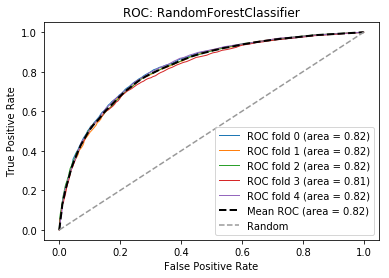

In [15]:
fig = plot_roc(X, y, rf, title='RandomForestClassifier')